# Spoof Detection using ViT-S/32 Medium Augmentation 

## Setup

In [1]:
!nvidia-smi

Mon Sep 27 17:04:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [2]:
!wget -q https://github.com/Codebugged-Research/ExamOnlineFinal/releases/download/1.0.0.0/spoof-dataset-final.zip
!unzip -qq spoof-dataset-final.zip

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

SEEDS = 42

tf.random.set_seed(SEEDS)
np.random.seed(SEEDS)

## Data Parsing

In [4]:
image_paths = list(paths.list_images("spoof-dataset-final"))
np.random.shuffle(image_paths)
image_paths[:5]

['spoof-dataset-final/Spoof/0001_00_02_03_223.jpg',
 'spoof-dataset-final/Spoof/0012_01_02_03_328.jpg',
 'spoof-dataset-final/Real/0004_01_06_03_441.jpg',
 'spoof-dataset-final/Spoof/0008_00_00_01_377.jpg',
 'spoof-dataset-final/Spoof/0005_00_01_02_319.jpg']

## Counting number of images for each classes

In [5]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'Spoof': 7509, 'Real': 5105})


## Splitting the dataset

In [6]:
TRAIN_SPLIT = 0.9

i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

11352 1262


## Define Hyperparameters

In [7]:
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
IMG_SIZE = 224
RESIZE_TO = 260
NUM_CLASSES = 2

## Encoding labels

In [8]:
label_encoder = LabelEncoder()
train_labels_le = label_encoder.fit_transform(train_labels)
validation_labels_le = label_encoder.transform(validation_labels)
print(train_labels_le[:5])

[1 1 0 1 1]


## Determine the class-weights

In [9]:
trainLabels = keras.utils.to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Convert the data into TensorFlow `Dataset` objects

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))

## Define the preprocessing function

In [12]:
@tf.function  
def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)
    return (image, label)

@tf.function
def preprocess_test(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    return (image, label)

## Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Create the Data Pipeline

In [14]:
pipeline_train = (
    train_ds
    .shuffle(BATCH_SIZE * 100)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

pipeline_validation = (
    val_ds
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the training images

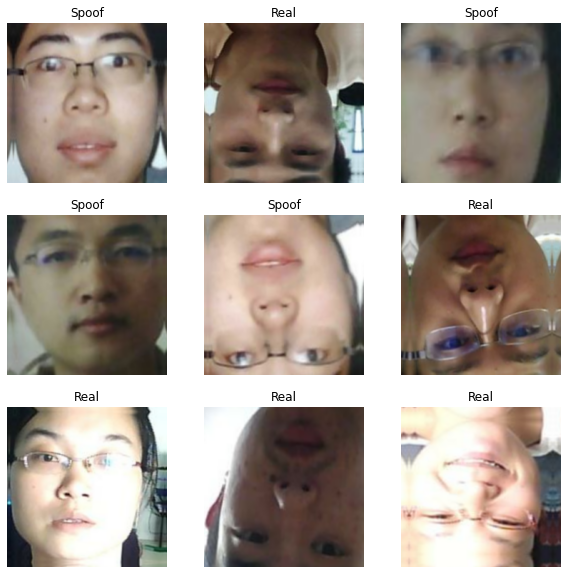

In [16]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(label_encoder.inverse_transform([label.numpy()])[0])
    plt.axis("off")

## Load model into KerasLayer

In [17]:
def get_training_model(trainable=False):
    # Load the MobileNetV3 model but exclude the classification layers
    EXTRACTOR = keras.applications.MobileNetV3Small(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = keras.layers.GlobalAveragePooling2D()(class_head)
    class_head = keras.layers.Dense(512, activation="relu")(class_head)
    class_head = keras.layers.Dropout(0.5)(class_head)
    class_head = keras.layers.Dense(NUM_CLASSES, activation="softmax")(class_head)

    # Create the new model
    classifier = tf.keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [18]:
model = get_training_model()

6709248/6698480 [==============================] - 0s 0us/step


## Setup Callbacks

In [19]:
train_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
    keras.callbacks.CSVLogger('./train-logs.csv'),
    keras.callbacks.TensorBoard(histogram_freq=1)
]

## Train the model

In [20]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs= EPOCHS, 
    validation_data=pipeline_validation,
    class_weight=classWeight,
    callbacks=train_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
45/45 [==============================] - 56s 769ms/step - loss: 0.2989 - accuracy: 0.8899 - val_loss: 0.0810 - val_accuracy: 0.9746
Epoch 2/100
45/45 [==============================] - 42s 867ms/step - loss: 0.0559 - accuracy: 0.9868 - val_loss: 0.0339 - val_accuracy: 0.9897
Epoch 3/100
45/45 [==============================] - 42s 873ms/step - loss: 0.0303 - accuracy: 0.9926 - val_loss: 0.0170 - val_accuracy: 0.9976
Epoch 4/100
45/45 [==============================] - 42s 869ms/step - loss: 0.0227 - accuracy: 0.9955 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 5/100
45/45 [==============================] - 42s 870ms/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.0081 - val_accuracy: 0.9984
Epoch 6/100
45/45 [==============================] - 42s 873ms/step - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.0053 - val_accuracy: 1.0000


## Plot the Metrics

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Evaluate the model

5/5 [==============================] - 1s 111ms/step - loss: 0.0101 - accuracy: 1.0000
Accuracy: 100.00%


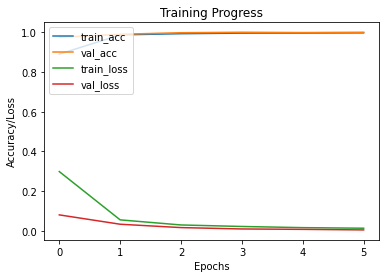

In [22]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

plot_hist(history)

In [ ]:
model.save('saved-model')

In [ ]:
!pip install -q  tensorflowjs

In [25]:
!tar -cvf "/content/saved-model.tar" "/content/saved-model"

tar: Removing leading `/' from member names
/content/saved-model/
/content/saved-model/assets/
/content/saved-model/variables/
/content/saved-model/variables/variables.index
/content/saved-model/variables/variables.data-00000-of-00001
/content/saved-model/keras_metadata.pb
/content/saved-model/saved_model.pb


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    /content/saved-model \
    /content/web_model

In [28]:
!tar -cvf "/content/web_model.tar" "/content/web_model/"

tar: Removing leading `/' from member names
/content/web_model/
/content/web_model/model.json
/content/web_model/group1-shard1of2.bin
/content/web_model/group1-shard2of2.bin


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
!tensorboard dev upload --logdir logs --name "Spoof Classification" --description "Spoof Classification using MobileNetV3"

https://tensorboard.dev/experiment/42f4MAh0R2C3QF2wR9ZSLw/